In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.5 MB/s eta 0:00:00


---

# Lib

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import keras.backend as K

import optuna

---

# Read file


In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/data/train.csv", encoding="utf-8")
df_val = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/data/val.csv", encoding="utf-8")

In [6]:
df_train.head()

,comment,label
0,giá thu_nhập việt hy_vọng tương_lại hãng xún đẹp,negative
1,kushaq apple carplay dây kết_nối tiện_lợi chuẩ...,positive
2,mua xe tôn tiền,neutral
3,xe đỉnh chuẩn xe châu_âu giá_cả,positive
4,nline lăn bánh terri trend cx5 deluxe chặn 2 đ...,negative


In [7]:
df_val.head()

,comment,label
0,chạy đường byd đẹp,positive
1,top bán_chạy mấy liền giá quyết_định chất xe ổ...,positive
2,yêu m2 trắng,positive
3,đầu to_cảng xệ_sát đất ưu lưng,negative
4,đuôi đẹp cầu kỳ,positive


---

# Labels

## Train

In [8]:
matrix_labels_train = df_train["label"]

In [9]:
matrix_labels_train.head()

,label
0,negative
1,positive
2,neutral
3,positive
4,negative


In [10]:
print(f"Number of labels: {len(matrix_labels_train.unique())}")
print(f"Labels: {matrix_labels_train.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


## Val

In [11]:
matrix_labels_val = df_val["label"]

In [12]:
matrix_labels_val.head()

,label
0,positive
1,positive
2,positive
3,negative
4,positive


In [13]:
print(f"Number of labels: {len(matrix_labels_val.unique())}")
print(f"Labels: {matrix_labels_val.unique()}")

Number of labels: 3
Labels: ['positive' 'negative' 'neutral']


---

# Train, val split


In [14]:
# Train
X_train = df_train[["comment"]]
y_train = matrix_labels_train

# Validation
X_val = df_val[["comment"]]
y_val = matrix_labels_val

In [15]:
# Encode labels
le= LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int64)
y_val = le.transform(y_val).astype(np.int64)

---

# Vectorize


In [16]:
vec = TfidfVectorizer(
    analyzer="char",
    min_df=3,
    max_df=0.95,
    ngram_range=(3, 5),
    max_features=30000,
)

In [17]:
# Fit TF-IDF on training and transform train/test
X_train_vec = vec.fit_transform(X_train["comment"])
X_val_vec = vec.transform(X_val["comment"])

In [18]:
# To dense arrays
X_train_vec = X_train_vec.toarray().astype(np.float32)
X_val_vec = X_val_vec.toarray().astype(np.float32)

In [19]:
print(f"Train shape: {X_train_vec.shape}")
print(f"Test shape: {X_val_vec.shape}")
print(f"Vocabulary size: {len(vec.get_feature_names_out())}")

Train shape: (3592, 28150)
Test shape: (770, 28150)
Vocabulary size: 28150


In [20]:
print("Number of classes (train): ", len(le.classes_))
print("Number of classes (val): ", len(le.classes_))

Number of classes (train):  3
Number of classes (val):  3


In [21]:
n_features = X_train_vec.shape[1]
n_classes = len(le.classes_)

---

# FNN (Feedforward neural Network)


## Model


In [22]:
# Build model function
def build_model(input_dim, output_dim, params):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        params["hidden1"],
        activation="relu",
        input_shape=(input_dim,),
        kernel_regularizer=l2(params.get("l2_reg", 0.01))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(params["dropout1"]))

    # Second hidden layer
    if params["n_layers"] >= 2:
        model.add(Dense(
            params["hidden2"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout2"]))

    # Third hidden layer
    if params["n_layers"] >= 3:
        model.add(Dense(
            params["hidden3"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout3"]))

    # Fourth hidden layer
    if params["n_layers"] >= 4:
        model.add(Dense(
            params["hidden4"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout4"]))

    # Single-label multiclass: softmax + sparse categorical crossentropy
    model.add(Dense(output_dim, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=params["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [23]:
# Objective function for Optuna
def objective(trial):
    params = {
        "n_layers": trial.suggest_int("n_layers", 2, 4),
        "hidden1": trial.suggest_categorical("hidden1", [16, 32, 64]),
        "hidden2": trial.suggest_categorical("hidden2", [16, 32, 64]),
        "hidden3": trial.suggest_categorical("hidden3", [16, 32, 64, 96]),
        "hidden4": trial.suggest_categorical("hidden4", [64, 96, 128]),
        "dropout1": trial.suggest_float("dropout1", 0.2, 0.5),
        "dropout2": trial.suggest_float("dropout2", 0.2, 0.5),
        "dropout3": trial.suggest_float("dropout3", 0.2, 0.5),
        "dropout4": trial.suggest_float("dropout4", 0.2, 0.5),
        "l2_reg": trial.suggest_float("l2_reg", 1e-3, 1e-1, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
    }

    model = build_model(input_dim=n_features, output_dim=n_classes, params=params)

    early_stop = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    # Use precomputed numeric vectors for training/validation
    model.fit(
        X_train_vec,
        y_train,
        validation_data=(X_val_vec, y_val),
        epochs=20,
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0,
    )

    y_val_prob = model.predict(X_val_vec)
    y_val_pred = np.argmax(y_val_prob, axis=1)

    f1 = f1_score(y_val, y_val_pred, average="macro")

    # Delete old TensorFlow graph and collect RAM
    K.clear_session() # Remove old TF graph
    gc.collect() # Collect garbage

    return f1

In [24]:
# Optuna study
study = optuna.create_study(direction="maximize", study_name="fnn_f1_macro")
study.optimize(objective, n_trials=20)

[I 2025-12-20 02:32:43,328] A new study created in memory with name: fnn_f1_macro


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[I 2025-12-20 02:33:09,986] Trial 0 finished with value: 0.22375611159045153 and parameters: {'n_layers': 4, 'hidden1': 32, 'hidden2': 32, 'hidden3': 32, 'hidden4': 96, 'dropout1': 0.42783752536940634, 'dropout2': 0.4883295040134387, 'dropout3': 0.37523347623683845, 'dropout4': 0.3804968120848138, 'l2_reg': 0.0026817312090953544, 'lr': 0.0008255663412007297, 'batch_size': 64}. Best is trial 0 with value: 0.22375611159045153.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-12-20 02:33:31,098] Trial 1 finished with value: 0.4485694985792281 and parameters: {'n_layers': 3, 'hidden1': 32, 'hidden2': 64, 'hidden3': 96, 'hidden4': 64, 'dropout1': 0.28938287587130607, 'dropout2': 0.3508750923238957, 'dropout3': 0.3678586351321167, 'dropout4': 0.4070778028170548, 'l2_reg': 0.0025897708032249006, 'lr': 0.0020105451101610134, 'batch_size': 64}. Best is trial 1 with value: 0.4485694985792281.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-12-20 02:33:54,612] Trial 2 finished with value: 0.46513200301979163 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 16, 'hidden3': 32, 'hidden4': 96, 'dropout1': 0.4368726941200689, 'dropout2': 0.3569707603054523, 'dropout3': 0.3765350817797061, 'dropout4': 0.36658237932646026, 'l2_reg': 0.008187846758760478, 'lr': 0.00019952136606006703, 'batch_size': 64}. Best is trial 2 with value: 0.46513200301979163.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-12-20 02:36:43,854] Trial 3 finished with value: 0.44507711883807977 and parameters: {'n_layers': 4, 'hidden1': 64, 'hidden2': 64, 'hidden3': 32, 'hidden4': 96, 'dropout1': 0.415936569874774, 'dropout2': 0.3972140975384374, 'dropout3': 0.23724438329082018, 'dropout4': 0.27670089909524076, 'l2_reg': 0.0015676545801545376, 'lr': 0.0062092606649867795, 'batch_size': 16}. Best is trial 2 with value: 0.46513200301979163.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2025-12-20 02:37:14,891] Trial 4 finished with value: 0.4691384081905123 and parameters: {'n_layers': 3, 'hidden1': 32, 'hidden2': 64, 'hidden3': 96, 'hidden4': 128, 'dropout1': 0.2956467381945972, 'dropout2': 0.3997609554263395, 'dropout3': 0.2087836471884611, 'dropout4': 0.3270678714663745, 'l2_reg': 0.0011819745509635486, 'lr': 0.009040205508032358, 'batch_size': 32}. Best is trial 4 with value: 0.4691384081905123.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-12-20 02:38:18,692] Trial 5 finished with value: 0.46687528010157636 and parameters: {'n_layers': 3, 'hidden1': 64, 'hidden2': 16, 'hidden3': 64, 'hidden4': 96, 'dropout1': 0.3150928869577759, 'dropout2': 0.3239165185763875, 'dropout3': 0.2514388640228229, 'dropout4': 0.3675527873425589, 'l2_reg': 0.03853702054996958, 'lr': 0.0016768878233454462, 'batch_size': 64}. Best is trial 4 with value: 0.4691384081905123.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-12-20 02:39:00,390] Trial 6 finished with value: 0.43642588781605296 and parameters: {'n_layers': 4, 'hidden1': 64, 'hidden2': 16, 'hidden3': 96, 'hidden4': 64, 'dropout1': 0.24347809804126488, 'dropout2': 0.27308511201558244, 'dropout3': 0.37186814255144174, 'dropout4': 0.28074291774912197, 'l2_reg': 0.005111024709375887, 'lr': 0.0010207265067282052, 'batch_size': 64}. Best is trial 4 with value: 0.4691384081905123.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-12-20 02:39:22,473] Trial 7 finished with value: 0.40455753138446365 and parameters: {'n_layers': 2, 'hidden1': 32, 'hidden2': 32, 'hidden3': 96, 'hidden4': 96, 'dropout1': 0.3067089130125475, 'dropout2': 0.2902883617872956, 'dropout3': 0.3652463898865551, 'dropout4': 0.35194759260951236, 'l2_reg': 0.003996162479646993, 'lr': 0.0015000140607268932, 'batch_size': 32}. Best is trial 4 with value: 0.4691384081905123.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-12-20 02:41:25,099] Trial 8 finished with value: 0.4777045650865757 and parameters: {'n_layers': 4, 'hidden1': 64, 'hidden2': 64, 'hidden3': 64, 'hidden4': 128, 'dropout1': 0.4672789695960965, 'dropout2': 0.39272429515515017, 'dropout3': 0.23608203266539962, 'dropout4': 0.4507005803829277, 'l2_reg': 0.034708548771387925, 'lr': 0.0003752601982030038, 'batch_size': 32}. Best is trial 8 with value: 0.4777045650865757.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-12-20 02:42:02,694] Trial 9 finished with value: 0.4498801449492091 and parameters: {'n_layers': 4, 'hidden1': 16, 'hidden2': 16, 'hidden3': 64, 'hidden4': 64, 'dropout1': 0.3865067000158594, 'dropout2': 0.38871540865425375, 'dropout3': 0.33604553810425614, 'dropout4': 0.49284323159770405, 'l2_reg': 0.06469801524281545, 'lr': 0.0013360815188432748, 'batch_size': 32}. Best is trial 8 with value: 0.4777045650865757.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[I 2025-12-20 02:45:10,851] Trial 10 finished with value: 0.45390643392863145 and parameters: {'n_layers': 4, 'hidden1': 64, 'hidden2': 64, 'hidden3': 16, 'hidden4': 128, 'dropout1': 0.4895910345515728, 'dropout2': 0.20055553326200348, 'dropout3': 0.4952683698259923, 'dropout4': 0.4745726665683773, 'l2_reg': 0.022455147986888337, 'lr': 0.00013796761345042272, 'batch_size': 16}. Best is trial 8 with value: 0.4777045650865757.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-12-20 02:46:04,784] Trial 11 finished with value: 0.4611025010265089 and parameters: {'n_layers': 3, 'hidden1': 32, 'hidden2': 64, 'hidden3': 64, 'hidden4': 128, 'dropout1': 0.24229962845128725, 'dropout2': 0.4572894602080759, 'dropout3': 0.20053585473548136, 'dropout4': 0.2162611552687917, 'l2_reg': 0.01714917275871831, 'lr': 0.00030675682757946594, 'batch_size': 32}. Best is trial 8 with value: 0.4777045650865757.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-12-20 02:47:17,914] Trial 12 finished with value: 0.44622434295235935 and parameters: {'n_layers': 3, 'hidden1': 64, 'hidden2': 64, 'hidden3': 16, 'hidden4': 128, 'dropout1': 0.36113182905791996, 'dropout2': 0.4294440902572835, 'dropout3': 0.28924664841767256, 'dropout4': 0.4376064352053187, 'l2_reg': 0.001038835436906253, 'lr': 0.009429579538100544, 'batch_size': 32}. Best is trial 8 with value: 0.4777045650865757.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


[I 2025-12-20 02:48:10,883] Trial 13 finished with value: 0.5096334283699169 and parameters: {'n_layers': 3, 'hidden1': 32, 'hidden2': 64, 'hidden3': 96, 'hidden4': 128, 'dropout1': 0.21123623438964756, 'dropout2': 0.42950975144279024, 'dropout3': 0.2067063242213445, 'dropout4': 0.3002576666927477, 'l2_reg': 0.09763781936249412, 'lr': 0.0004720913857021753, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-12-20 02:48:36,374] Trial 14 finished with value: 0.506064411198412 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 64, 'hidden3': 64, 'hidden4': 128, 'dropout1': 0.20491332743572682, 'dropout2': 0.45587404413043386, 'dropout3': 0.29125837496232987, 'dropout4': 0.28884351342724535, 'l2_reg': 0.0958565223702215, 'lr': 0.0004229973397768041, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-12-20 02:48:57,908] Trial 15 finished with value: 0.4265583621759698 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 64, 'hidden3': 96, 'hidden4': 128, 'dropout1': 0.20532821946533641, 'dropout2': 0.49744730607148635, 'dropout3': 0.30085781336533846, 'dropout4': 0.2943205984969873, 'l2_reg': 0.06261829078492626, 'lr': 0.0005623994089404475, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-12-20 02:49:37,871] Trial 16 finished with value: 0.47895559565437534 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 32, 'hidden3': 64, 'hidden4': 128, 'dropout1': 0.2148533530123529, 'dropout2': 0.44786872562954333, 'dropout3': 0.4255039519215559, 'dropout4': 0.2490911599032487, 'l2_reg': 0.09912804175114864, 'lr': 0.00039058674927135227, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-12-20 02:50:08,812] Trial 17 finished with value: 0.3896247240618102 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 64, 'hidden3': 16, 'hidden4': 128, 'dropout1': 0.2629997464402667, 'dropout2': 0.4324168651747421, 'dropout3': 0.28289443739056974, 'dropout4': 0.3162096243615853, 'l2_reg': 0.09365426729494522, 'lr': 0.003942873882278024, 'batch_size': 16}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-12-20 02:50:29,107] Trial 18 finished with value: 0.4462012728719173 and parameters: {'n_layers': 2, 'hidden1': 16, 'hidden2': 64, 'hidden3': 64, 'hidden4': 128, 'dropout1': 0.3372838285445356, 'dropout2': 0.4734256446538672, 'dropout3': 0.3235830561314172, 'dropout4': 0.20639147209766529, 'l2_reg': 0.013930856966817964, 'lr': 0.0005871758551972503, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-12-20 02:51:30,630] Trial 19 finished with value: 0.4515738498789346 and parameters: {'n_layers': 3, 'hidden1': 32, 'hidden2': 32, 'hidden3': 96, 'hidden4': 128, 'dropout1': 0.2551447122784254, 'dropout2': 0.42867609061551376, 'dropout3': 0.25785779778419804, 'dropout4': 0.24851738063573936, 'l2_reg': 0.03754917107579235, 'lr': 0.00011452023660866386, 'batch_size': 32}. Best is trial 13 with value: 0.5096334283699169.


In [25]:
print("Best f1:", study.best_value)
print("Best trial:", study.best_trial.number)

Best f1: 0.5096334283699169
Best trial: 13


In [26]:
best_params = study.best_params

print("Best params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Best params:
  n_layers: 3
  hidden1: 32
  hidden2: 64
  hidden3: 96
  hidden4: 128
  dropout1: 0.21123623438964756
  dropout2: 0.42950975144279024
  dropout3: 0.2067063242213445
  dropout4: 0.3002576666927477
  l2_reg: 0.09763781936249412
  lr: 0.0004720913857021753
  batch_size: 32


In [27]:
# Build final model with best hyperparameters
model = build_model(n_features, n_classes, best_params)

In [28]:
# Fit final model
model.fit(
    X_train_vec, y_train, epochs=20, batch_size=best_params["batch_size"], verbose=1
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3788 - loss: 14.3411
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5651 - loss: 8.7351
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6820 - loss: 5.8051
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7485 - loss: 3.9902
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7958 - loss: 2.8990
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8228 - loss: 2.2575
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8219 - loss: 1.8650
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8405 - loss: 1.5688
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8418 - loss: 1.4070
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8601 - loss: 1.2480
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8658 - loss: 1.1578
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━

## Eval validation


In [29]:
# Predict
y_prob = model.predict(X_val_vec)
y_pred = np.argmax(y_prob, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [30]:
# Compute metrics
metrics = {
    "accuracy_score": accuracy_score(y_val, y_pred),
    "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
}

matrix_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["score"])

In [31]:
matrix_metrics.round(4)

,score
accuracy_score,0.6247
precision_macro,0.4909
recall_macro,0.4794
f1_macro,0.4721


In [32]:
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

    negative       0.58      0.68      0.63       303
     neutral       0.20      0.06      0.10        78
    positive       0.69      0.69      0.69       389

    accuracy                           0.62       770
   macro avg       0.49      0.48      0.47       770
weighted avg       0.60      0.62      0.61       770



## Eval test


In [35]:
df_test = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/data/test.csv")
df_test_predict = df_test.copy()
df_test_predict.shape

(770, 2)

In [36]:
# Try prediction on some samples
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples).toarray()

# Use the trained final model for predictions
probs = model.predict(samples_vec)
preds = np.argmax(probs, axis=1)

for i, (text, pred_idx) in enumerate(zip(samples, preds)):
    label_name = le.inverse_transform([pred_idx])[0]
    confidence = probs[i][pred_idx]
    df_test_predict.at[i, "predicted_label"] = label_name
    df_test_predict.at[i, "confidence"] = confidence

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [37]:
df_test_predict.head()

,comment,label,predicted_label,confidence
0,ngoại thất hiện_đại hẳn,positive,neutral,0.738675
1,thương_hiệu ninsan chỗ chê gtr nổi_tiếng khấp ...,positive,positive,0.723482
2,xe trung_quốc thiết_kế đẹp,positive,positive,0.955295
3,giá trưng_bày,negative,negative,0.919974
4,vụ tai_nạn mấy hôm trung_quốc vios sởn gai_ốc ...,negative,positive,0.527285


In [38]:
print(classification_report(df_test["label"], df_test_predict["predicted_label"], target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

    negative       0.63      0.71      0.67       304
     neutral       0.12      0.05      0.07        78
    positive       0.73      0.74      0.73       388

    accuracy                           0.66       770
   macro avg       0.49      0.50      0.49       770
weighted avg       0.63      0.66      0.64       770



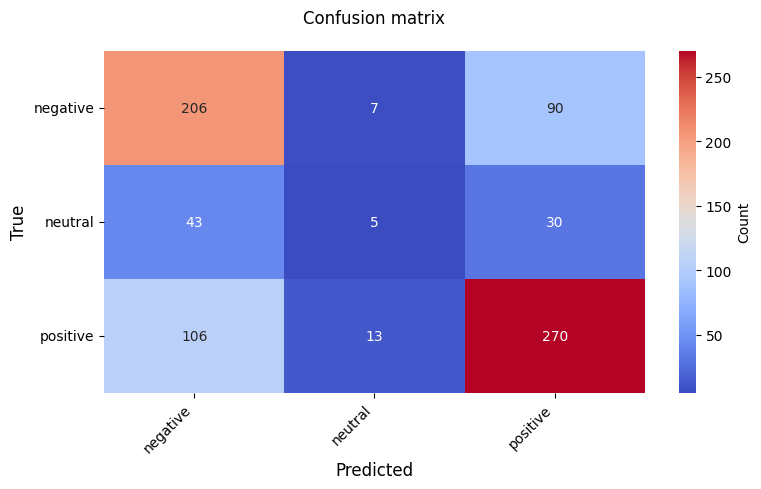

In [40]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion matrix', pad=20)
plt.ylabel('True', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

# Save model

In [42]:
model.save("/content/drive/MyDrive/Code/nlp-prj/models/fnn.keras")